# Overview of Week 3

This week's assignment consists of two parts. The first part gives you an introduction to unsupervised learning. In particular, we focus on techniques for clustering and dimensionality reduction and how they can be applied to ecommerce data. As you work through the three clustering case studies, you will find yourself generating many intermediate datasets, trying different models, and tuning each model as you go along. There's a lot to keep track of.   

This is where Part 2 comes in. It is in Part 2 that we introduce ideas of **workflow management** and **computational reproducibility**. Workflow management means organising your project directory to manage your analysis' artefacts (visualisations, processed datasets, notebooks and utility functions and experiment results). Ideally, your code for these should be clearly commented with well chosen names. Computational reproducibility means someone else (including future you!) being able to take just the code and data, and reproduce your project, from its results and models to visualisations etc. How one decides to practice workflow management and computational reproducibility can be quite a personal decision. Therefore, we provide guidelines, not rules. The most important is having a system rather than no system at all. 

**note about the week**   
While week 1's assignment was guided, with specific instructions about what code to run, as we move on the assignments will involve less hand-holding. For this week, we include some instructions, but leave the specific implementations up to you. There are also many techniques we cover. Again, while we share some resources, we leave the bulk of the research and background reading up to you to manage for yourself. As a record of how well you have synthesised your readings, this notebook has space for writing a few paragraphs of explanations. We hope you won't be content with a shallow explanation, and that you use this space to apply the [Feynmann technique](https://collegeinfogeek.com/feynman-technique/) as a check of understanding. 

To tie Part 1 and Part 2 of the week together, we are not just asking for one Jupyter Notebook as a final deliverable. Instead, there are four deliverables to the week: 

**1. Part 1 Notebook I and II exercises presented at the end of the week job-interview style**

**2. A script that automates the data cleaning and feature engineering steps you take so your findings are reproducible (see Part 2 Notebook I for more info)**

**3. A repo README.md (see Part 2 Notebook I for more info)**

**4  A record of software package versions and software environment used (see Part 2 Notebook I for more info)**   

**recap of the objectives for the first 6 weeks:**  
We aim to broadly cover a wide range of Machine Learning algorithms so that you can: 
- handle the technical demands of a 100E given some guidance on the right direction to take 
- can handle a technical job interview and get hired 

*materials for unsupervised learning adapted from William Thji* 

# Part I : Unsupervised Learning 
Unsupervised Learning refers to a set of machine learning techniques where no output variables (Y) are given. Only the input variables (X) are available and our job is to find patterns in X. You may read more about it from *pg 485 from Hastie and Tibshirani's Elements of Statistical Learning* available [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). 

ESL by Hastie et. al with be the primary reference for this week, although feel free to source for your own books and links. 

## Short introduction to clustering 
Clustering puts datapoints into subsets so that datapoints within a cluster are more closely related to one another compared to datapoints in another cluster. More information is available from page 501 of *Elements of Statistical Learning*. 

Some quick points: 
- Clustering is extremely useful to many fields: 
    - Customer segmentation for personalised product recommendations
    - Topic identification to relieve the need to manually vet documents 
    - Image or geo-spatial segmentation to optimised supply and demand (Gojek does this) 
    - and maybe most importantly, getting a sense of the data before starting to model it. 

- Some examples of clustering algorithms: 
    - KMeans
    - Gaussian Mixture Models for drawing soft clustering boundaries instead of hard ones 
    - Hierarchical clustering
    - DBScan for density-based clustering for anomaly detection 
    - Co-clustering
    - Biclustering for analysing genes

## Deliverable 1: Complete the Clustering Case Study: Using PCA and clustering to uncover customer segments 
Context: The dataset we will be working with contains ecommerce transactions from a UK-based online retails store. The dataset is available on [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data/home) or the UCI Machine Learning Repository. The dataset is quite small, so we have also included it inside the `data` folder inside this repo as `data/raw/data.csv`. 

From the Kaggle website: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Case Study Goal 
Cluster the dataset into meaningful customer segments. This means creating clusters that are statistically robust and that make business sense. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.cm as cm
from scipy import stats

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
df_raw = pd.read_csv('data/raw/data.csv', encoding='ISO-8859-1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Cleaning data 

Some data types are muddled, there are duplicates, NA values and unreasonable values hiding in the columns 

1. Clean the dataset. You may want to list the steps taken to clean the data and encapsulate the steps inside their own functions so they can be reused. Organise the functions into their own library

In [3]:
print('Dataframe shape:', df_raw.shape)
df_raw.isna().sum()

Dataframe shape: (541909, 8)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

About 25% of the data does not contain the CustomerID. It is not really possible to impute or guess the correct CustomerID for each entry. Without the CustomerID it is not possible to identify the records to belong to which customer to find out which segments that they might belong. Hence those records without CustomerID are dropped.

In [4]:
def dropEntryWithoutCustomerID(df_input):
    df_output = df_input.dropna(axis=0, subset=['CustomerID'])
    print('Dataframe shape after dropping entry with NA CustomerID:', df_output.shape)
    return df_output

df = dropEntryWithoutCustomerID(df_raw)

Dataframe shape after dropping entry with NA CustomerID: (406829, 8)


In [5]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
print('Number of duplicated entries: {}'.format(df.duplicated().sum()))

Number of duplicated entries: 5225


In [7]:
def dropDuplicatedEntries(df_input):
    df_output = df_input.drop_duplicates()
    print('Dataframe shape after dropping duplicates:', df_output.shape)
    return df_output

df = dropDuplicatedEntries(df)

Dataframe shape after dropping duplicates: (401604, 8)


In [8]:
df.groupby(by=['Country'], as_index=False).count().sort_values(by=['InvoiceNo'],ascending=False)

,Country,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
35,United Kingdom,356728,356728,356728,356728,356728,356728,356728
14,Germany,9480,9480,9480,9480,9480,9480,9480
13,France,8475,8475,8475,8475,8475,8475,8475
10,EIRE,7475,7475,7475,7475,7475,7475,7475
30,Spain,2528,2528,2528,2528,2528,2528,2528
23,Netherlands,2371,2371,2371,2371,2371,2371,2371
3,Belgium,2069,2069,2069,2069,2069,2069,2069
32,Switzerland,1877,1877,1877,1877,1877,1877,1877
26,Portugal,1471,1471,1471,1471,1471,1471,1471
0,Australia,1258,1258,1258,1258,1258,1258,1258


In [9]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


### Feature Engineering iteration #1 

Inside the dataset, each row contains information about an ecommerce transation. However, we want to cluster the data by customers, which means each row should instead contain information about a customer. 

1. Reshape the data to follow the format below: 
![alt text](customer.png)

The dataframe should have these columns: `['NoOfInvoices', 'NoOfUniqueItems', 'QuantityPerInvoice', 'TotalQuantity', 'UniqueItemsPerInvoice','UnitPriceMean','UnitPriceStd']` 
2. Save this dataset as an intermediate dataset 

In [11]:
def featureEngineer(df):
    temp = df[df.Quantity > 0]
    intermediate = temp.groupby(['CustomerID']).agg({'InvoiceNo': "nunique",
                                         'StockCode': "nunique",
                                          'Quantity': ["sum",'count'],
                                          'UnitPrice': ['mean','std']})
    
    # Using ravel, and a string join, we can create better names for the columns:
    intermediate.columns = ["_".join(x) for x in intermediate.columns.ravel()]
    
    intermediate['QuantityPerInvoice'] = intermediate['Quantity_sum']/intermediate['InvoiceNo_nunique']
    intermediate['UniqueItemsPerInvoice'] = intermediate['Quantity_count']/intermediate['InvoiceNo_nunique']
    
    intermediate.drop(['Quantity_sum'], axis=1, inplace=True)
    
    intermediate.rename(columns={'InvoiceNo_nunique':'NoOfInvoices','StockCode_nunique':'NoOfUniqueItems',
                             'Quantity_count':'TotalQuantity','UnitPrice_mean':'UnitPriceMean',
                            'UnitPrice_std':'UnitPriceStd'}, inplace=True)
    
    intermediate.fillna(0, inplace=True)
    
    return intermediate

intermediate = featureEngineer(df)

intermediate.head()

,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
CustomerID,,,,,,,
12346.0,1,1,1,1.040000,0.000000,74215.000000,1.00
12347.0,7,103,182,2.644011,2.255381,351.142857,26.00
12348.0,4,22,31,5.764839,13.400323,585.250000,7.75
12349.0,1,73,73,8.289041,35.028021,631.000000,73.00
12350.0,1,17,17,3.841176,9.334751,197.000000,17.00


### Hierarchical clustering iteration #1 [reference pg 520](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. Implement any more preprocessing or visualisation steps you feel are necessary to understand how you might build meaningful clusters from the data. 
2. Apply hierarchical clustering to the dataset. 
2. Experiment with different linkage algorithms. Visualise the resulting trees for average linkage, complete linkage and single linkage side-by-side. Which linkage algorithm works best? 
3. List two ways to improve the clustering and implement at least one. Track the results of the first iteration and second iteration (whether with Excel, TextEdit or within this notebook itself). 
4. Describe the clusters you selected and evaluate whether or not they form meaningful segments. 

In [12]:
scaler = StandardScaler()
intermediate_scaled = scaler.fit_transform(intermediate)

In [13]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

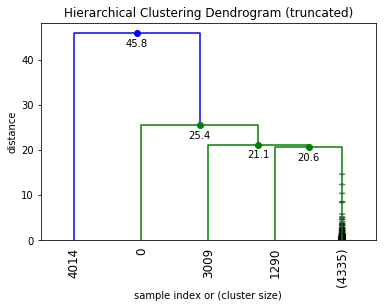

In [14]:
Zs = linkage(intermediate_scaled, 'single')

fancy_dendrogram(
    Zs,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,                    # show only the last p merged clusters
    leaf_rotation=90.,      # rotates the x axis labels
    leaf_font_size=12.,     # font size for the x axis labels
    show_contracted=True,   # to get a distribution impression in truncated branches
    annotate_above=10,      # useful in small plots so annotations don't overlap
)

plt.show()

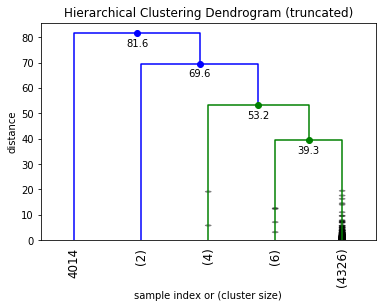

In [15]:
Zc = linkage(intermediate_scaled, 'complete')

fancy_dendrogram(
    Zc,
    truncate_mode='lastp',
    p=5,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)

plt.show()

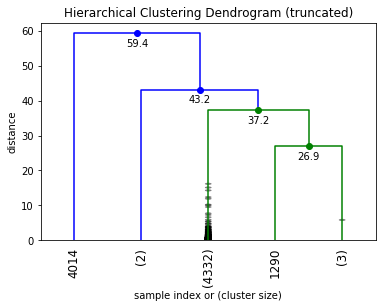

In [16]:
Za = linkage(intermediate_scaled, 'average')

fancy_dendrogram(
    Za,
    truncate_mode='lastp',
    p=5,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)

plt.show()

#### Comparing between Single, Complete and Average Linkage
truncate_mode was set using lastp. This setting display the last p non-singleton clusters formed in the linkage. All other non-singleton clusters are contracted into leaf nodes. p is arbiturarily set to 5 to potentially give a useful number of groups for the business teams to target.

With p set to 5 (till 12), all three linkage algorithm don't seem to cluster well. The bulk of the customers are already placed in 1 cluster (99%). Since this hierarchical clustering make use of aggregation instead of division, it is likely that there are many outliers which gets grouped into the cluster at the last time iteration hence creating this issue.

#### Improve the clustering
1) One of the way to improve the clustering is to try other linkage algorithm to see if other treatment of the distance between clusters works better for this dataset.
<br>
2) Another alternative is to do more feature engineering and create features that might potentially create better clusters.
<br>
3) Look for outliers and remove them since they might potentially affect the clustering.

#### Cluster improvement implementation
The ward linkage algorithm with p set to 7 appears to give better clustering that the previous attempt done using single, complete and average linkage algorithm. 4 small clusters (< 12 customers) and 3 large clusters (>550 customers) were created. The 4 small clusters can be merged into 1 to create 4 distinct clusters for the business teams to target.

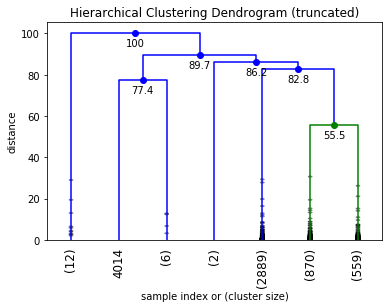

In [17]:
Zw = linkage(intermediate_scaled, 'ward')

fancy_dendrogram(
    Zw,
    truncate_mode='lastp',
    p=7,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)

plt.show()

In [18]:
max_d = 55
clusters = fcluster(Zw, max_d, criterion='distance')
clusters

array([4, 6, 5, ..., 5, 6, 5], dtype=int32)

In [19]:
# Reset the CustomerID index back into normal column
intermediate_reset = intermediate.reset_index(level=0, inplace=False)

# Join the cluster labels with the dataset
clusters_df = pd.DataFrame(clusters)
labelled = pd.concat([intermediate_reset, clusters_df], axis=1)

labelled.rename(columns={0:'Clusters'}, inplace=True)

labelled.head()

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice,Clusters
0,12346.0,1,1,1,1.040000,0.000000,74215.000000,1.00,4
1,12347.0,7,103,182,2.644011,2.255381,351.142857,26.00,6
2,12348.0,4,22,31,5.764839,13.400323,585.250000,7.75,5
3,12349.0,1,73,73,8.289041,35.028021,631.000000,73.00,7
4,12350.0,1,17,17,3.841176,9.334751,197.000000,17.00,5


In [20]:
labelled.groupby(by=['Clusters']).count()

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
Clusters,,,,,,,,
1,12,12,12,12,12,12,12,12
2,6,6,6,6,6,6,6,6
3,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,2
5,2889,2889,2889,2889,2889,2889,2889,2889
6,870,870,870,870,870,870,870,870
7,559,559,559,559,559,559,559,559


In [21]:
labelled.loc[labelled.Clusters <= 4, 'Clusters'] = 1
labelled.loc[labelled.Clusters == 5, 'Clusters'] = 2
labelled.loc[labelled.Clusters == 6, 'Clusters'] = 3
labelled.loc[labelled.Clusters == 7, 'Clusters'] = 4

In [22]:
labelled.groupby(by=['Clusters'])['CustomerID'].count()

Clusters
1      21
2    2889
3     870
4     559
Name: CustomerID, dtype: int64

In [23]:
labelled_analysis = labelled.groupby(['Clusters']).agg({'CustomerID': "count",
                                                        'NoOfInvoices': "mean",
                                                        'NoOfUniqueItems': "mean",
                                                        'TotalQuantity': "mean",
                                                        'UnitPriceMean': "mean",
                                                        'UnitPriceStd': "mean",
                                                        'QuantityPerInvoice': "mean",
                                                        'UniqueItemsPerInvoice': "mean"})
labelled_analysis

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
Clusters,,,,,,,,
1,21,56.190476,555.809524,1844.619048,150.865654,133.457330,6086.113679,37.373311
2,2889,2.255798,26.776393,30.978193,4.175810,3.932138,191.742178,14.279500
3,870,10.717241,127.749425,202.224138,3.096946,3.584632,241.420769,22.727926
4,559,2.710197,119.196780,158.432916,2.614534,2.683610,386.321422,58.881558


In [24]:
Zw_silhouette_avg = silhouette_score(intermediate_scaled, labelled['Clusters'])
print("The average silhouette_score is :", Zw_silhouette_avg)

The average silhouette_score is : 0.4435752780848063


C:\Users\Raymond\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Raymond\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Raymond\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Raymond\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


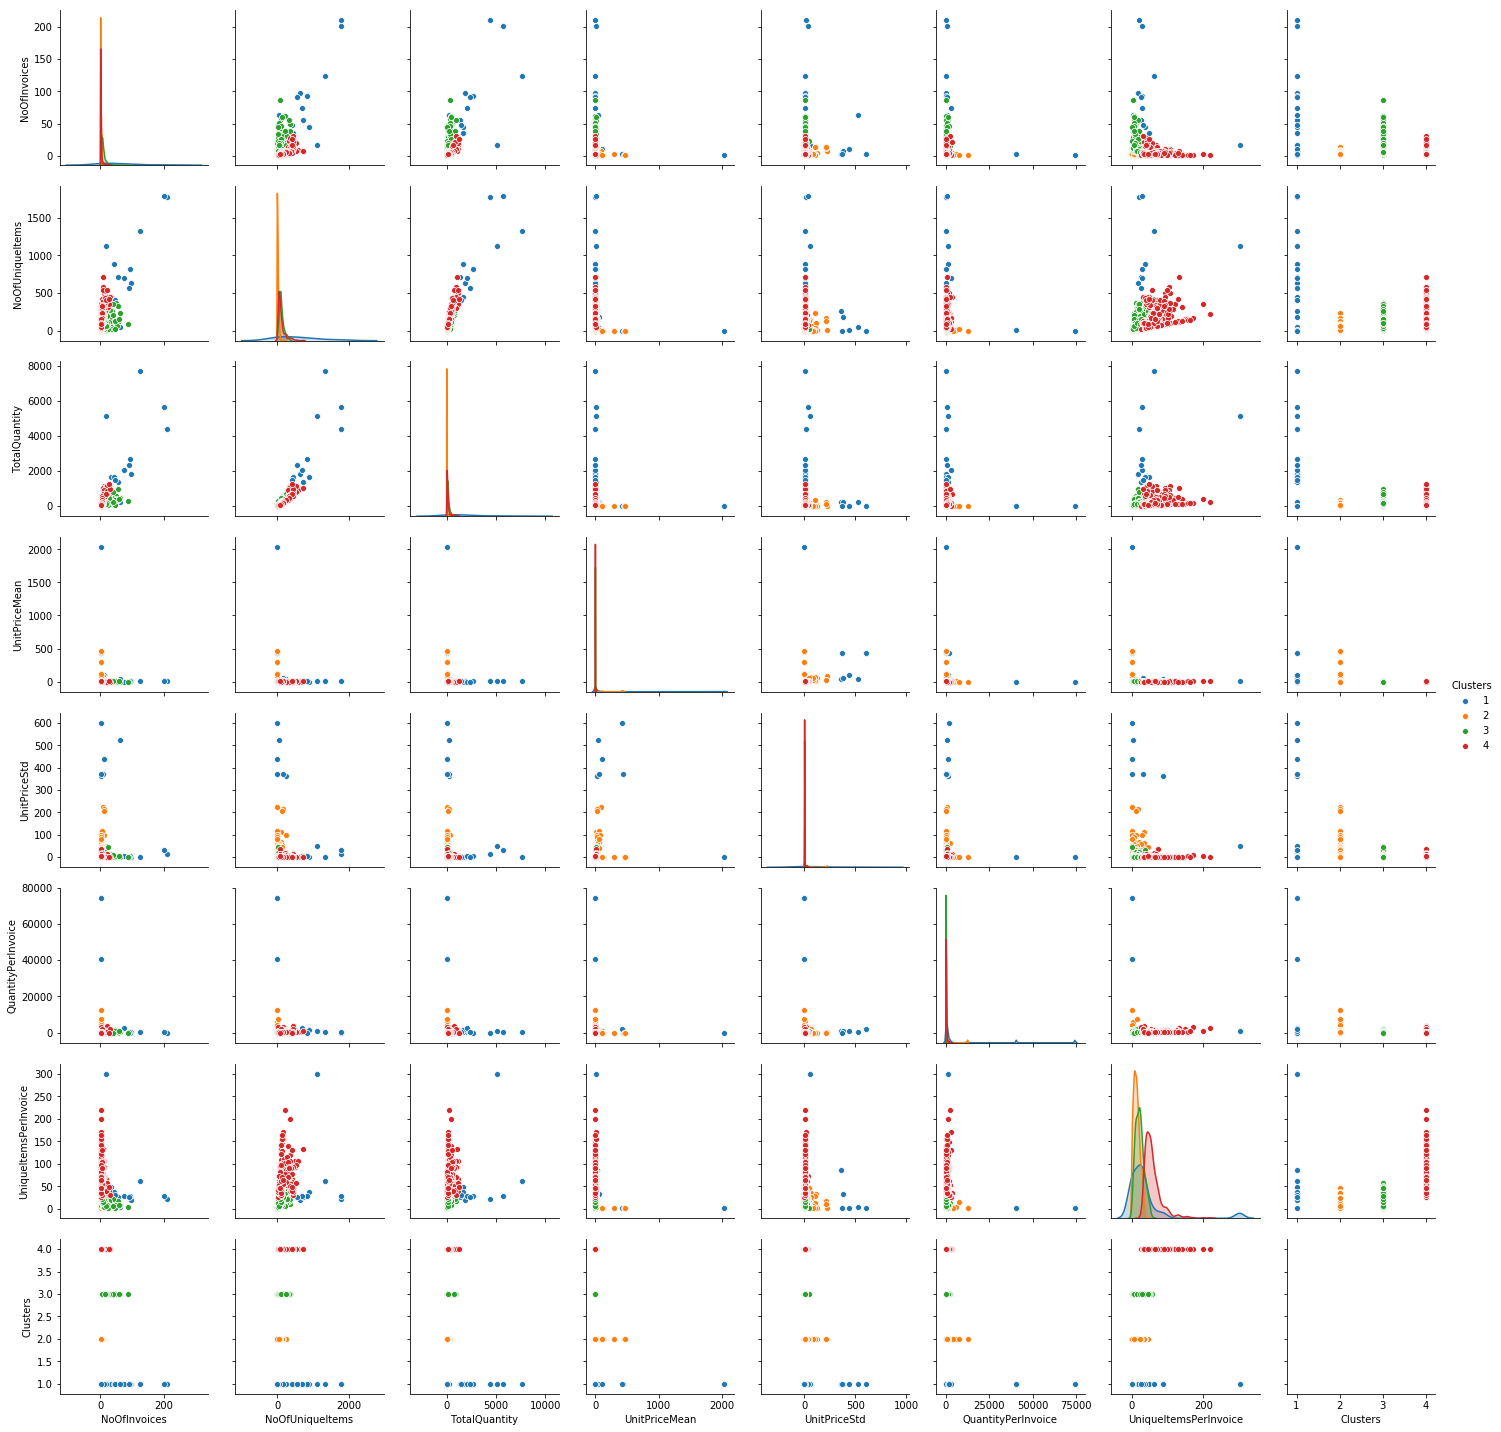

In [25]:
g = sns.pairplot(labelled.drop(['CustomerID'], axis=1), hue="Clusters")

#### Analysis of the clusters
The mean values of all the feature are analysed to make sense of the 4 clusters. The clusters also have a positive average silhouette score which is a good sign.

Cluster 1 appears to be high spenders. They have large number of invoices in the 1 year period and each invoices consist of a lot of purchases. This cluster are likely our premium customers.

Cluster 2 are the bulk of the customers and they appear to be the low spenders. They only have 2 invoices on average per year and each invoice only have very low number of purchases.

Cluster 3 and 4 are the mid spenders. Cluster 3 have relatively high invoices but buy lesser each time. While Cluster 4 has small number of invoices but buy a lot each time.

### K-means and GMM Clustering iteration #1 [reference pg 509](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
Apart from hierarchical clustering, we can also apply KMeans and Gaussian Mixture Models (GMM) on the data

1. Implement K-means clustering on the data, experimenting with different values of k 
2. Implement a Gaussian Mixture Model on the data, experimenting with different values for the number of components.  
3. Visualise how well K-means and GMMs succeed at separating subgroups in the data
4. List two ways to improve the clustering and implement at least one. 
5. Describe the clusters and evaluate whether or not they form meaningful segments. 

### K-means implementation

For n_clusters = 2 The average silhouette_score is : 0.9421559524001272
For n_clusters = 3 The average silhouette_score is : 0.5562843580803809
For n_clusters = 4 The average silhouette_score is : 0.5668857190726823
For n_clusters = 5 The average silhouette_score is : 0.56767299188473
For n_clusters = 6 The average silhouette_score is : 0.5730677312085851


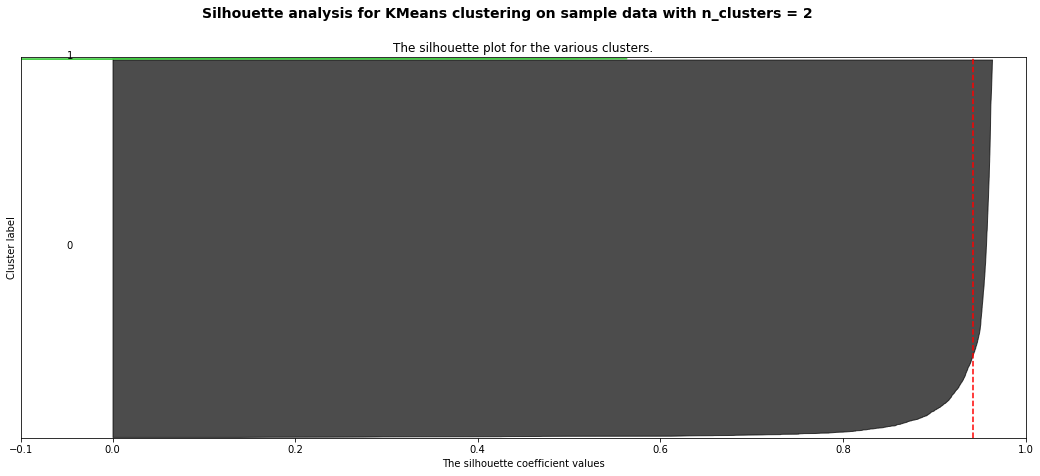

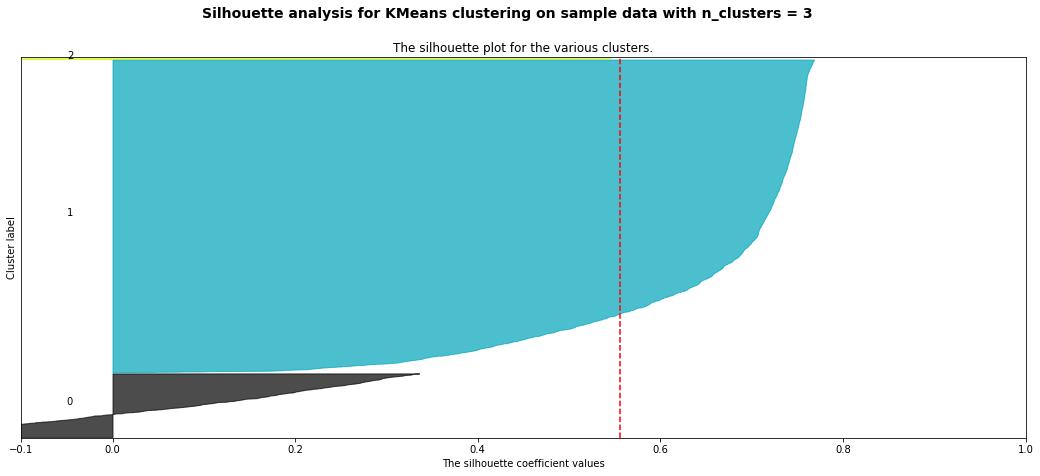

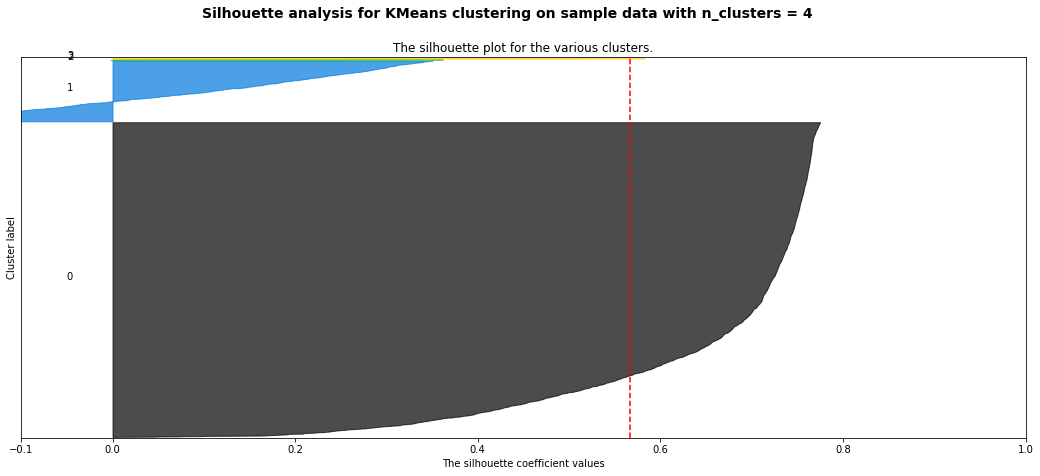

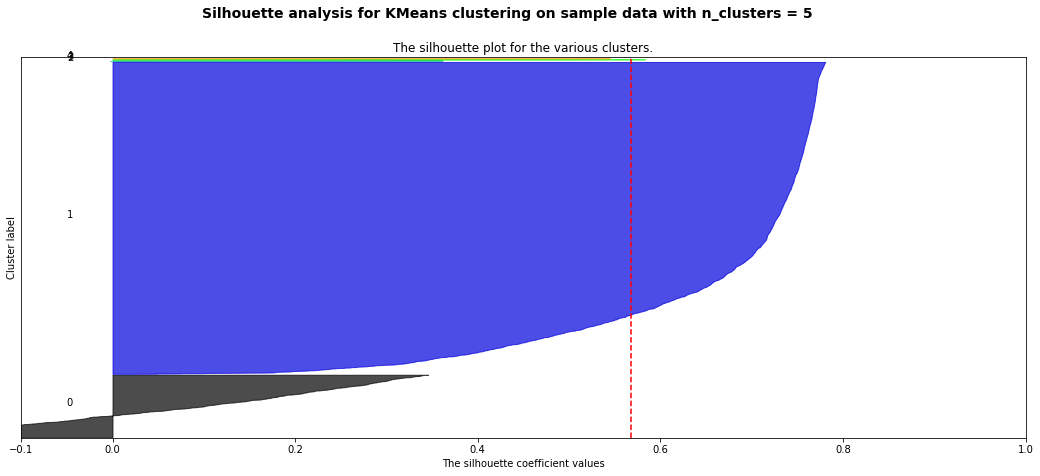

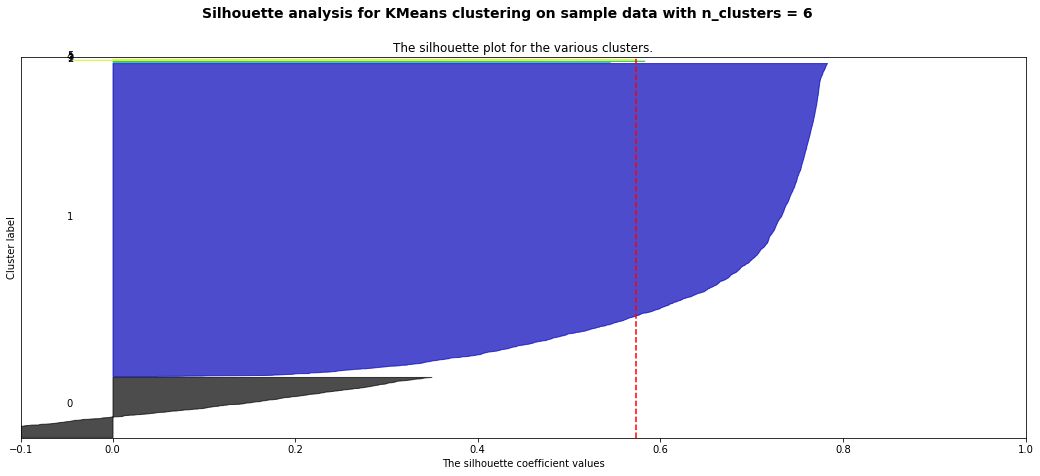

In [26]:
range_n_clusters = [2, 3, 4, 5, 6]
X = intermediate_scaled

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Selection of number of cluster for visualisation
After 2 clusters, the silhuoette score decreases quite significantly and you see that most data points are stuck within one cluster. There isn't a clearly better number of cluster in this case, so cluster of 4 is picked for later visualisation because this was used in the hierarchical clustering in the previous section.

In [27]:
kmeans4 = KMeans(n_clusters=4)
kmeans4.fit(intermediate_scaled)
labels4 = kmeans4.predict(intermediate_scaled)

labels4

array([0, 0, 0, ..., 0, 2, 0])

In [28]:
# PREPARATION OF DATAFRAME FOR VISUALISATION
# UNSCALED VERSION OF DATAFRAME WAS USED

# Join the cluster labels with the dataset
labels4_df = pd.DataFrame(labels4)
kmeans4_outcome = pd.concat([intermediate_reset, labels4_df], axis=1)

kmeans4_outcome.rename(columns={0:'Clusters'}, inplace=True)

kmeans4_outcome.head()

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice,Clusters
0,12346.0,1,1,1,1.040000,0.000000,74215.000000,1.00,0
1,12347.0,7,103,182,2.644011,2.255381,351.142857,26.00,0
2,12348.0,4,22,31,5.764839,13.400323,585.250000,7.75,0
3,12349.0,1,73,73,8.289041,35.028021,631.000000,73.00,2
4,12350.0,1,17,17,3.841176,9.334751,197.000000,17.00,0


In [29]:
kmeans4_outcome.groupby(by=['Clusters'])['CustomerID'].count()

Clusters
0    3560
1       8
2     763
3       8
Name: CustomerID, dtype: int64

In [46]:
kmeans4_outcome_analysis = kmeans4_outcome.groupby(['Clusters']).agg({'CustomerID': "count",
                                                        'NoOfInvoices': "mean",
                                                        'NoOfUniqueItems': "mean",
                                                        'TotalQuantity': "mean",
                                                        'UnitPriceMean': "mean",
                                                        'UnitPriceStd': "mean",
                                                        'QuantityPerInvoice': "mean",
                                                        'UniqueItemsPerInvoice': "mean"})
kmeans4_outcome_analysis

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
Clusters,,,,,,,,
0,3560,3.132303,35.778371,44.761236,3.926530,3.647300,236.874870,16.067312
1,8,113.375000,1090.000000,3976.125000,3.361448,14.195712,642.657708,64.172195
2,763,8.364351,170.657929,263.195282,2.839163,3.645382,332.447606,48.342140
3,8,12.000000,62.375000,94.375000,402.042558,362.742053,708.494841,16.042460


### Gaussian Mixture Implementation

In [46]:
kmeans4_outcome_analysis = kmeans4_outcome.groupby(['Clusters']).agg({'CustomerID': "count",
                                                        'NoOfInvoices': "mean",
                                                        'NoOfUniqueItems': "mean",
                                                        'TotalQuantity': "mean",
                                                        'UnitPriceMean': "mean",
                                                        'UnitPriceStd': "mean",
                                                        'QuantityPerInvoice': "mean",
                                                        'UniqueItemsPerInvoice': "mean"})
kmeans4_outcome_analysis

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
Clusters,,,,,,,,
0,3560,3.132303,35.778371,44.761236,3.926530,3.647300,236.874870,16.067312
1,8,113.375000,1090.000000,3976.125000,3.361448,14.195712,642.657708,64.172195
2,763,8.364351,170.657929,263.195282,2.839163,3.645382,332.447606,48.342140
3,8,12.000000,62.375000,94.375000,402.042558,362.742053,708.494841,16.042460


For n_components = 2 The average silhouette_score is : 0.06186746409065785
For n_components = 3 The average silhouette_score is : 0.0582181783583975
For n_components = 4 The average silhouette_score is : 0.042044472472668265
For n_components = 5 The average silhouette_score is : 0.35513466456793613
For n_components = 6 The average silhouette_score is : 0.021643849753035405


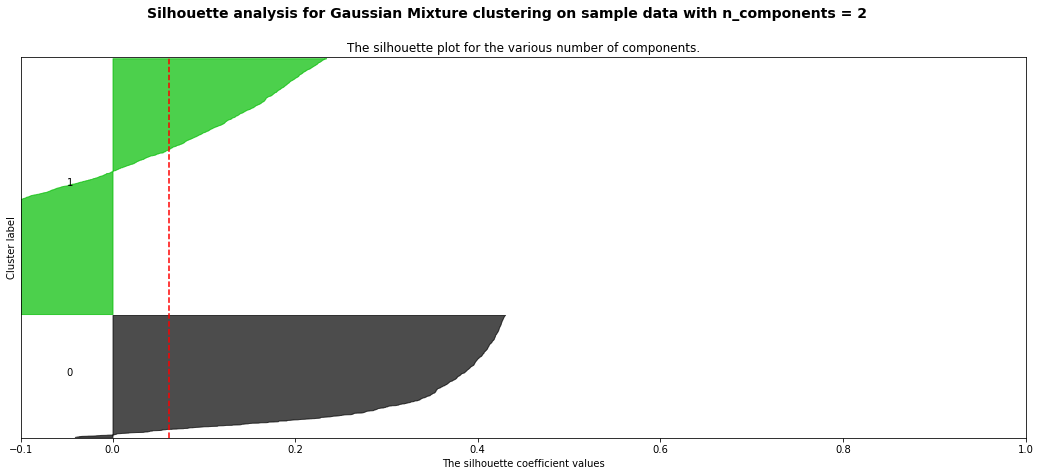

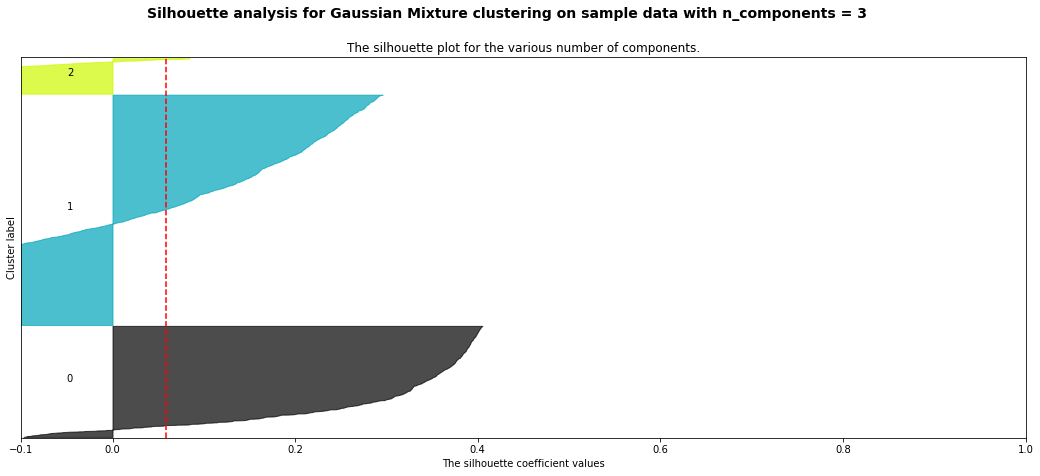

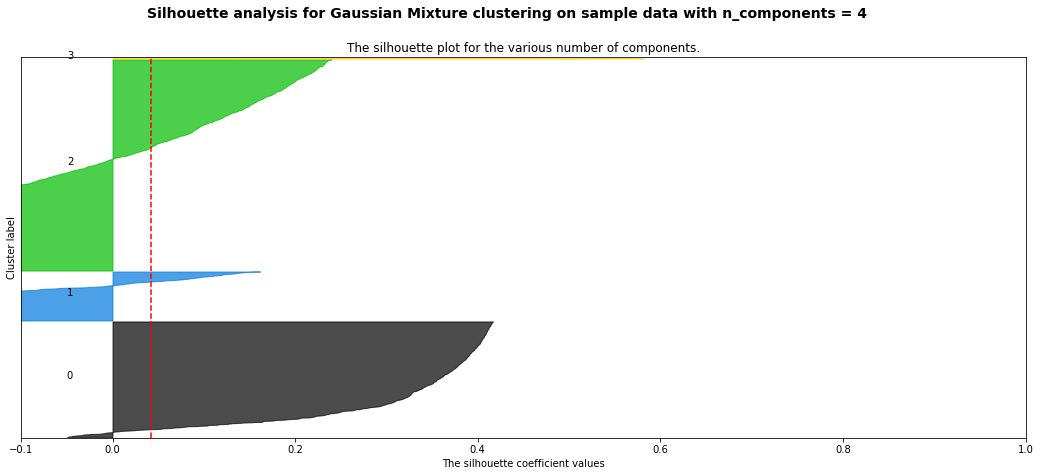

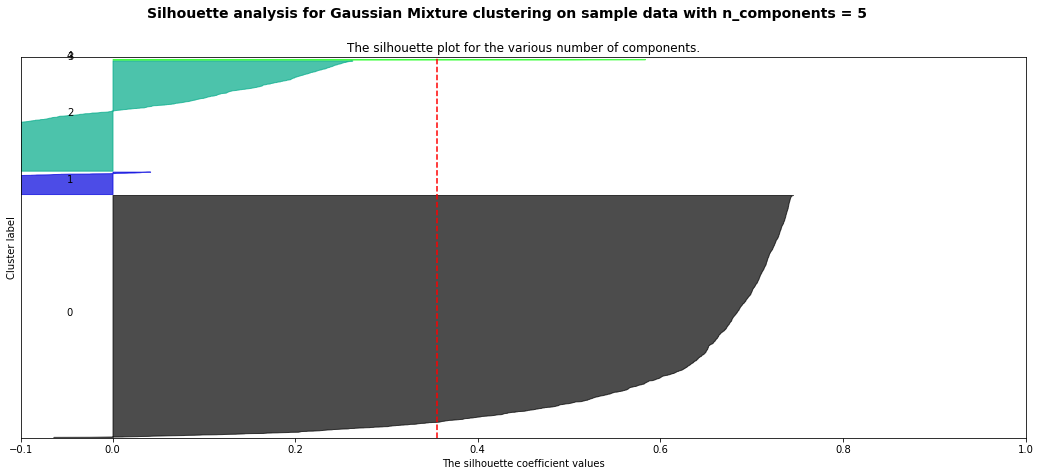

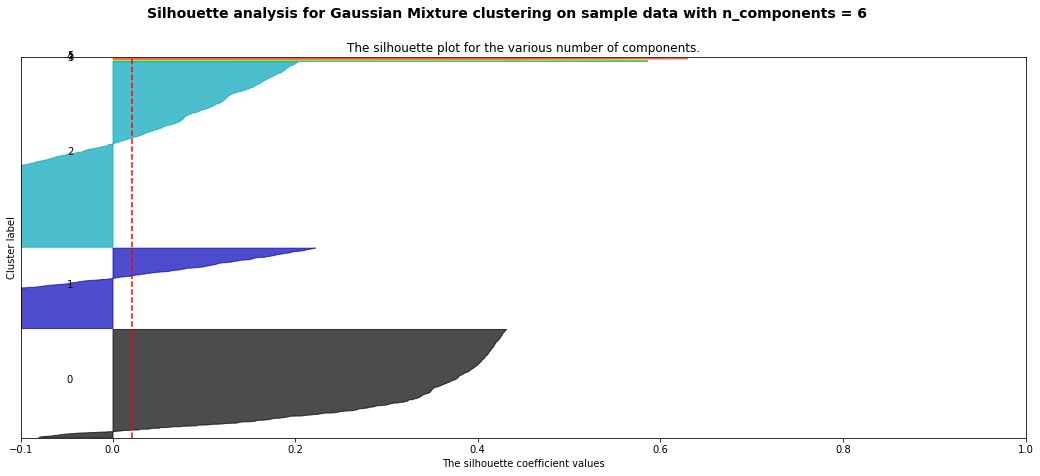

In [30]:
range_n_clusters = [2, 3, 4, 5, 6]
X = intermediate_scaled

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=7)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_components =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various number of components.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    plt.suptitle(("Silhouette analysis for Gaussian Mixture clustering on sample data "
                  "with n_components = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [31]:
# PREPARATION OF DATAFRAME FOR VISUALISATION
# UNSCALED VERSION OF DATAFRAME WAS USED
gmm = GaussianMixture(n_components=5,random_state =7)
gmm.fit(intermediate_scaled)
gmmlabels = gmm.predict(intermediate_scaled)

gmmlabels_df = pd.DataFrame(gmmlabels)
gmm_outcome = pd.concat([intermediate_reset, gmmlabels_df], axis=1)

gmm_outcome.rename(columns={0:'Clusters'}, inplace=True)

gmm_outcome.groupby(by=['Clusters'])['CustomerID'].count()

Clusters
0    2798
1     260
2    1276
3       4
4       1
Name: CustomerID, dtype: int64

In [33]:
gmm_outcome_analysis = gmm_outcome.groupby(['Clusters']).agg({'CustomerID': "count",
                                                        'NoOfInvoices': "mean",
                                                        'NoOfUniqueItems': "mean",
                                                        'TotalQuantity': "mean",
                                                        'UnitPriceMean': "mean",
                                                        'UnitPriceStd': "mean",
                                                        'QuantityPerInvoice': "mean",
                                                        'UniqueItemsPerInvoice': "mean"})
gmm_outcome_analysis

,CustomerID,NoOfInvoices,NoOfUniqueItems,TotalQuantity,UnitPriceMean,UnitPriceStd,QuantityPerInvoice,UniqueItemsPerInvoice
Clusters,,,,,,,,
0,2798,2.068620,28.923517,32.003931,3.251914,2.927469,165.788502,16.331133
1,260,14.615385,135.419231,283.980769,18.300738,27.895465,310.381028,21.050770
2,1276,6.579154,113.375392,161.815831,2.728427,2.536806,440.045527,33.813407
3,4,138.000000,1499.250000,5718.000000,4.085025,25.118423,416.723581,102.945869
4,1,1.000000,1.000000,1.000000,2033.100000,0.000000,1.000000,1.000000


### Visualisation of K-means Clustering

C:\Users\Raymond\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Raymond\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Raymond\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Raymond\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


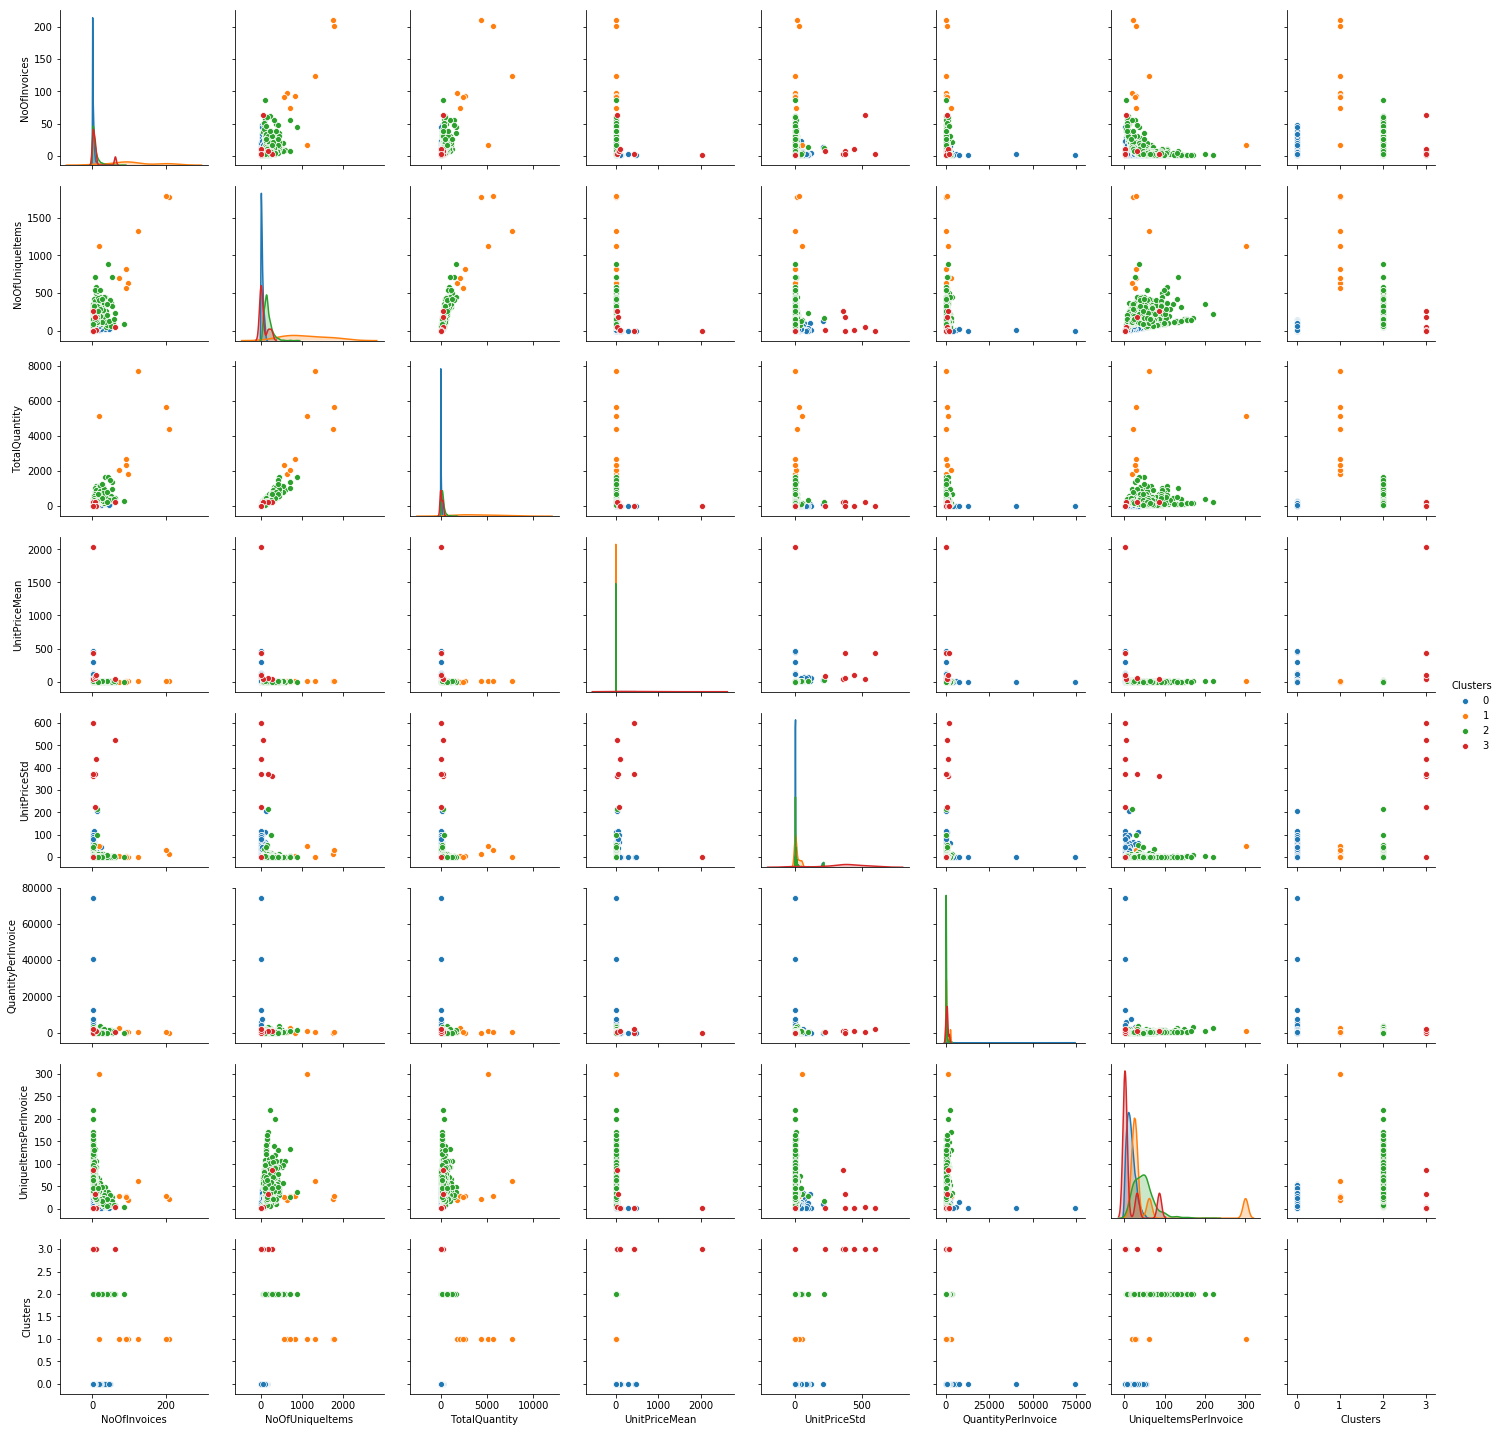

In [34]:
g = sns.pairplot(kmeans4_outcome.drop(['CustomerID'], axis=1), hue="Clusters")

### Visualisation of GMM Clustering

C:\Users\Raymond\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Raymond\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Raymond\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Raymond\Anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\Users\Raymond\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: Run

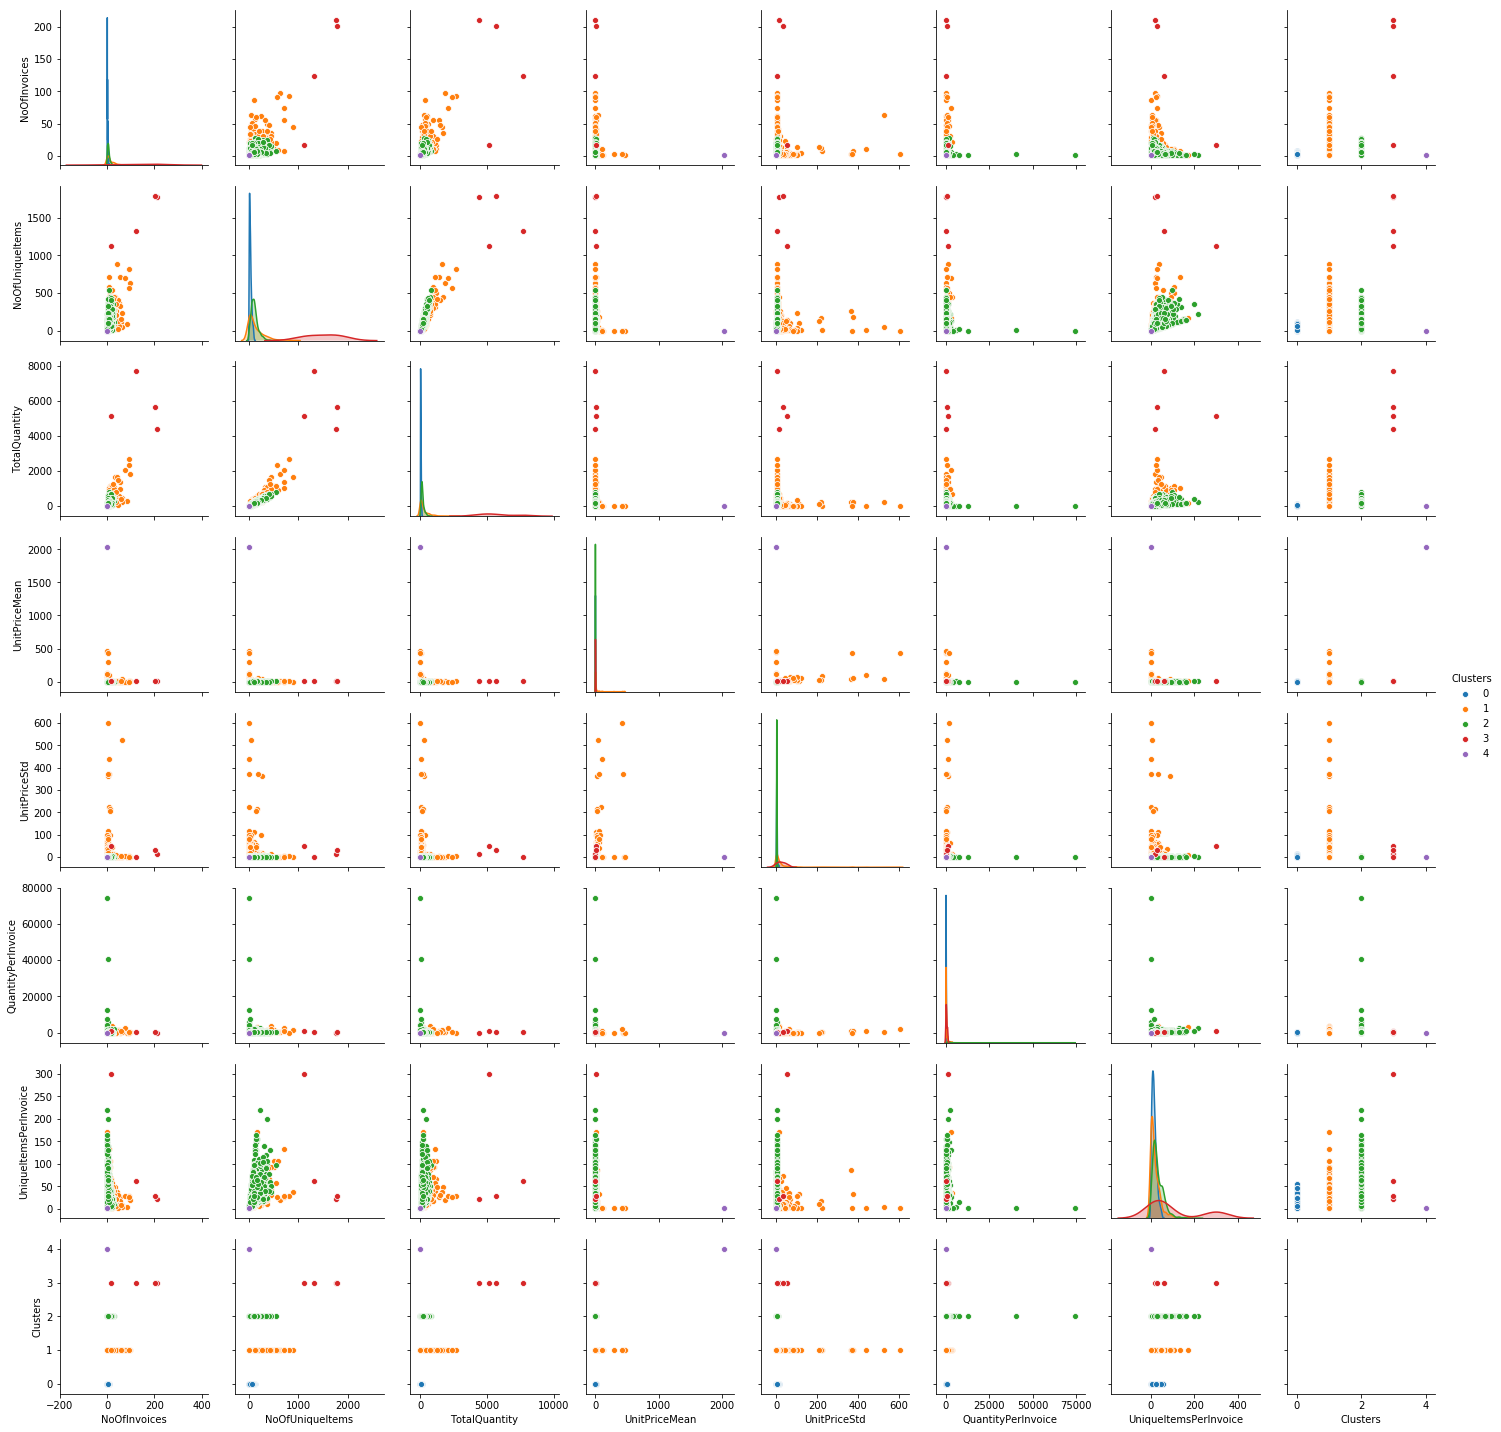

In [35]:
g = sns.pairplot(gmm_outcome.drop(['CustomerID'], axis=1), hue="Clusters")

### Outliers 

1. Do outliers influence the results of your Hierarchical Clustering, K-means and GMM models?  
2. Do the outliers themselves form clusters? 

1) Yes they do. They would distort the clusters or result in many small cluster.
<br>
2) Yes they might create small clusters. Like in the approach for the hierarchical clustering where ward algorithm was used, the outliers were grouped together to form a clusters. This group of outliers might be useful for the business team as they might be special customers that could have unique business approaches tailored to them.

### Validating clusters  

1. Use at least three techniques to validate that your chosen clusters correspond to meaningful customer segments. You may consider a combination of using visualisations and/or quantitative metrics (refer to Elements of Statistical Learning for some examples)

1) The average silhouette score was used to see how good the clusters are as a whole.
<br>
2) The silhouette plot was used to visualise the distribution of each data points silhouette score.
<br>
3) Pairplot can be used to visually see how the clusters are being distributed within each variables.

### Model selection

1. Explain when it is appropriate to use K-Means, GMM and Hierarchical Clustering 
2. Which model would you choose for this dataset? 

1) Hierachical clustering works well if there are not many outliers. For ideal outcome with hierarchical clustering, outliers should be removed from the dataset. K-means works well when the distribution of the data are spherical whereas GMM would work better when the distribution are not. 
<br>
<br>
2) For this dataset, K-Means seem to be preferred. It has the best average silhouette score and have 4 clusters that can be used for business. 2 large main cluster and 2 very small clusters of potential outliers. 1 large cluster with low spenders that represents the bulk of the customers and 1 large cluster of mid spenders. The other 2 small clusters are high spenders that can be targeted by the business team individually.

### Opening the black box of clustering [reference pg 503](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

1. In your own words, explain the broad idea behind building a proximity matrix to cluster data. (This should also be verbally presented during Monday's presentation). 
*Sometimes, typing values into MS Excel helps with building intuition

1) Proximity matrix starts off by measuring the distance of each point to all the other data points. The closest 2 points are grouped together as a cluster.
<br>
2) Then depends on what similarity algorithm is used, the points are clustered based on it.
    Min) The distance between the 2 closest point of 2 clusters are considered for similarity.
    Max/Complete) The distance between the 2 furthest point of 2 clusters are considered for similiarity.
    Average) The mean distance of all points within a cluster to another cluster are compared for similiarity.
    Centroid) The center of all the data points in a cluster is considered as the centroid. The distance between cluster's centroid is used to consider for similarity.

2. In your own words, how would you calculate the disimilarity between objects in a dataset? (This should also be verbally presented during Monday's presentation)

Silhouette score can be used to calculate the disimilarity between objects in a dataset after clusters are formed.

The Silhouette score is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b).

It ranges between -1 to 1. With negatives values meaning the data point is likely in the wrong cluster. 0 will mean the point is on the boundary between 2 clusters. And a positive value means it is likely in the correct cluster.

### PCA for Dimensionality Reduction 

1. Using the dataset that you have pre-processed, construct a pairplot again. How is it different from the a plot of the raw data and what is your interpretation?  
2. Apply PCA pre-processed dataset. More information on PCA here [link]
3. Create a plot of cumulative explained variance and number of components. How does this inform you about the best number of components to select? 
4. Create a plot of PC0 against PC1, coloured by the GMM's predictions on the normalised dataset with outliers removed for n_components =7
5. How do the values of principal components relate to the original dataset

### Pair plot of the raw data

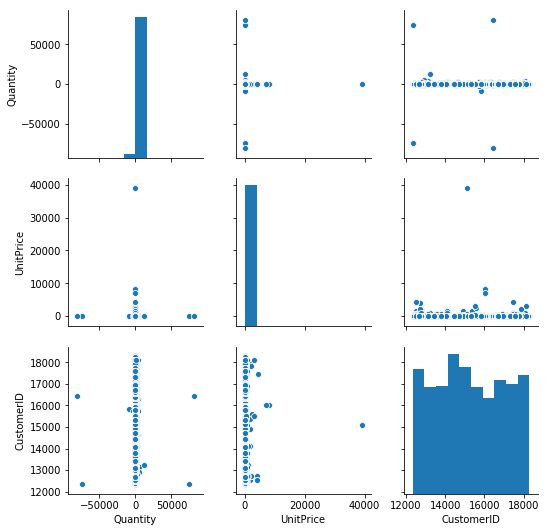

In [36]:
g = sns.pairplot(df)

### Pair plot of the preprocessed data

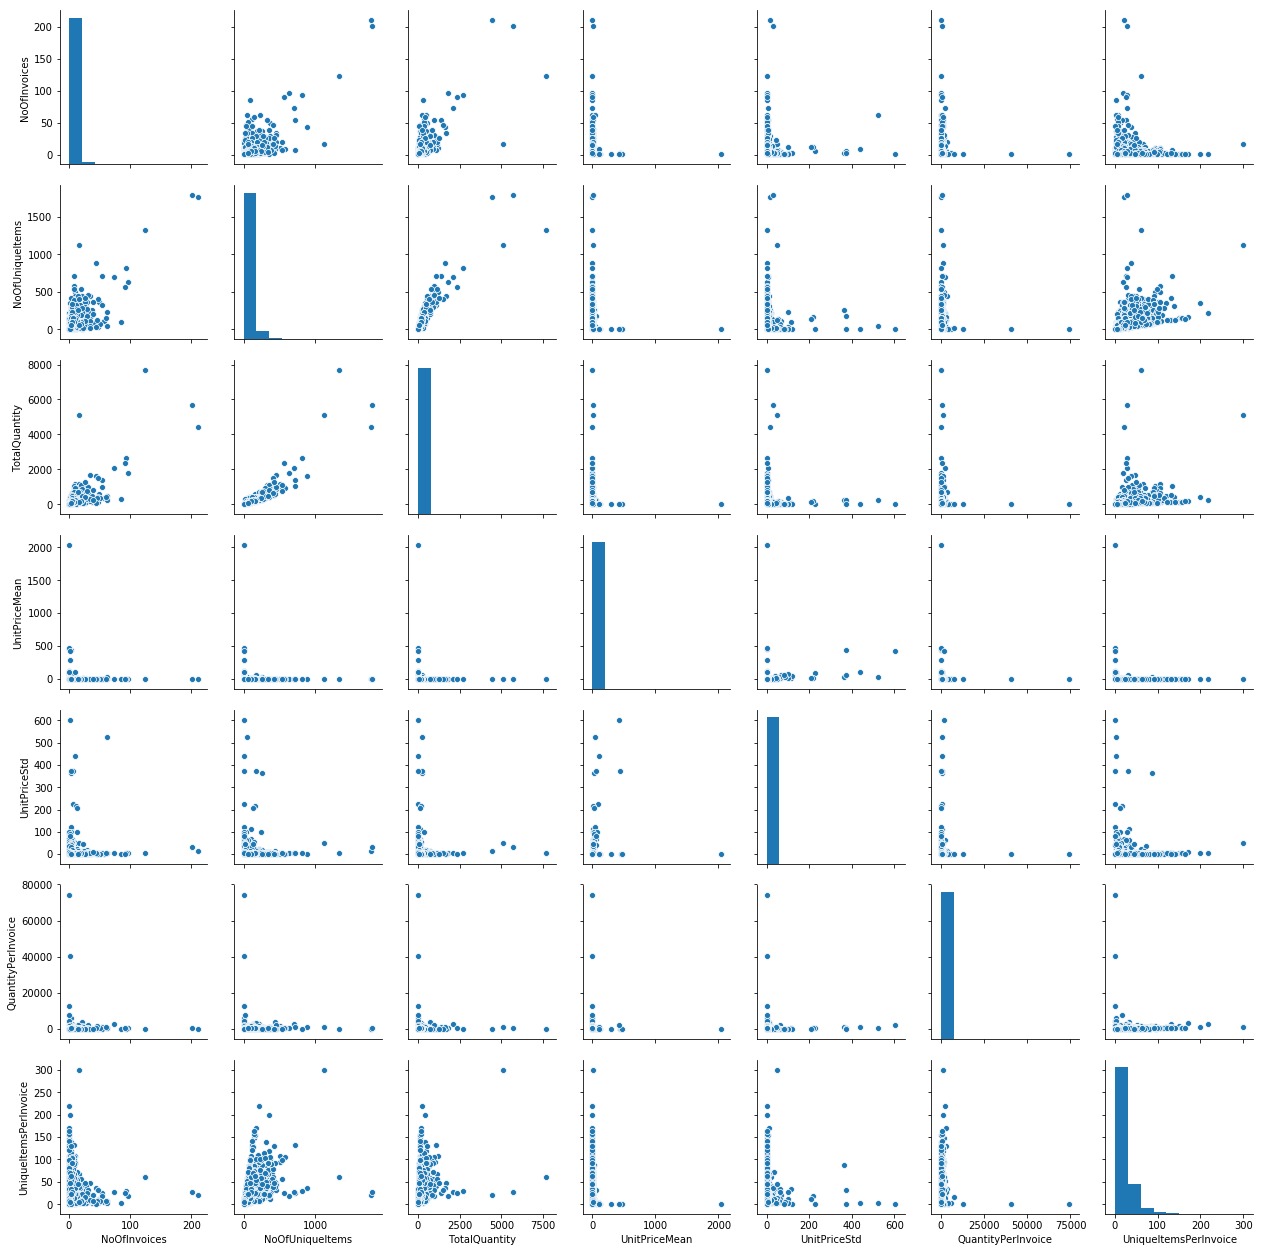

In [37]:
g = sns.pairplot(intermediate)

### How different is the raw data from the preprocessed data?
The raw data has few variables that are numerical for plotting. The preprocessed data have more numerical variables that could help in clustering.

### Plot of cumulative explained variance and number of components
This tells us how many components are required to explained the variance in the entire dataset. With more variables used, the amount of variance explained will increase.

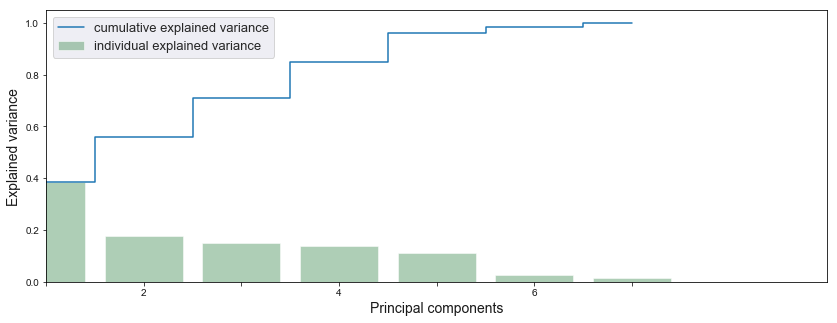

In [38]:
pca = PCA()
pca.fit(intermediate_scaled)
pca_samples = pca.transform(intermediate_scaled)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(intermediate_scaled.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,intermediate_scaled.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 8)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

##### Removing Outliers with more than 3 standard deviation

In [39]:
z = np.abs(stats.zscore(intermediate_scaled))
print(z)

[[ 0.42467  0.70869  0.39697 ...  0.23048 55.79114  1.06089]
 [ 0.35408  0.48634  0.40573 ...  0.11039  0.0723   0.2123 ]
 [ 0.0353   0.46265  0.26392 ...  0.48306  0.2489   0.71713]
 ...
 [ 0.29488  0.57981  0.34819 ...  0.02915  0.15373  0.80625]
 [ 1.52221  2.36088  2.79609 ...  0.17128  0.12861  1.1831 ]
 [ 0.16509  0.02916  0.09097 ...  0.16514  0.20621  0.07649]]


In [40]:
intermediate_scaled_3sd = intermediate_scaled[(z < 3).all(axis=1)]

In [41]:
print(intermediate_scaled.shape)
print(intermediate_scaled_3sd.shape)

(4339, 7)
(4147, 7)


In [42]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(intermediate_scaled_3sd)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC0', 'PC1'])

gmm_pca = GaussianMixture(n_components=7,random_state =7)
gmm_pca.fit(principalDf)
gmm_pca_labels = gmm_pca.predict(principalDf)

gmmlabels_df = pd.DataFrame(gmm_pca_labels)

gmm_pca = pd.concat([principalDf, gmmlabels_df], axis=1)

gmm_pca.rename(columns={0:'Clusters'}, inplace=True)

In [43]:
silhouette_avg = silhouette_score(principalDf, gmm_pca_labels)
silhouette_avg

0.08834214494900455

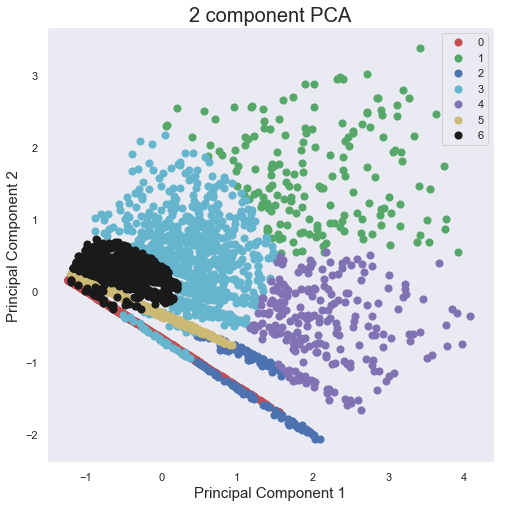

In [44]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3, 4, 5, 6]
colors = ['r', 'g', 'b', 'c', 'm','y','k']
for target, color in zip(targets,colors):
    indicesToKeep = gmm_pca['Clusters'] == target
    ax.scatter(gmm_pca.loc[indicesToKeep, 'PC0']
               , gmm_pca.loc[indicesToKeep, 'PC1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

For n_clusters = 2 The average silhouette_score is : 0.5210504891313829
For n_clusters = 3 The average silhouette_score is : 0.5266591455968485
For n_clusters = 4 The average silhouette_score is : 0.41626331767862207
For n_clusters = 5 The average silhouette_score is : 0.4389721221033577
For n_clusters = 6 The average silhouette_score is : 0.4171815691757992


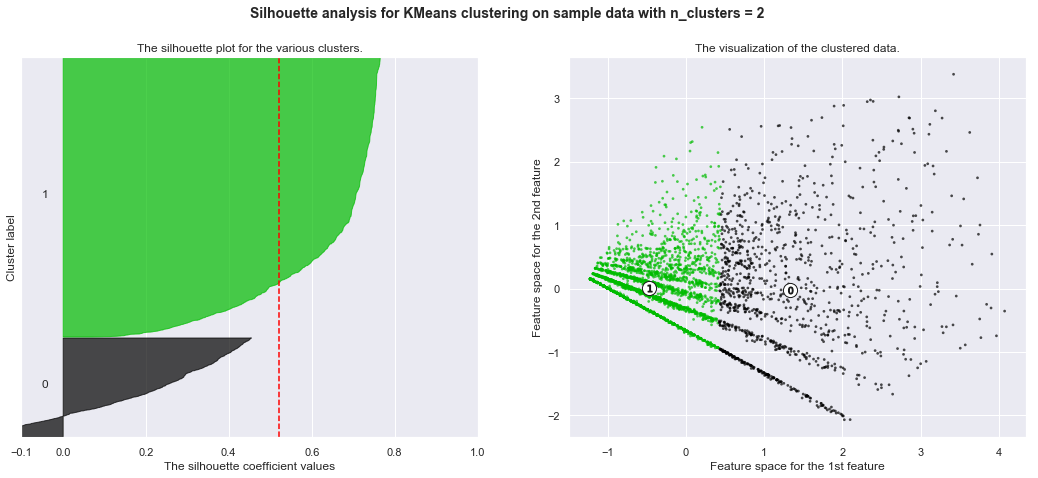

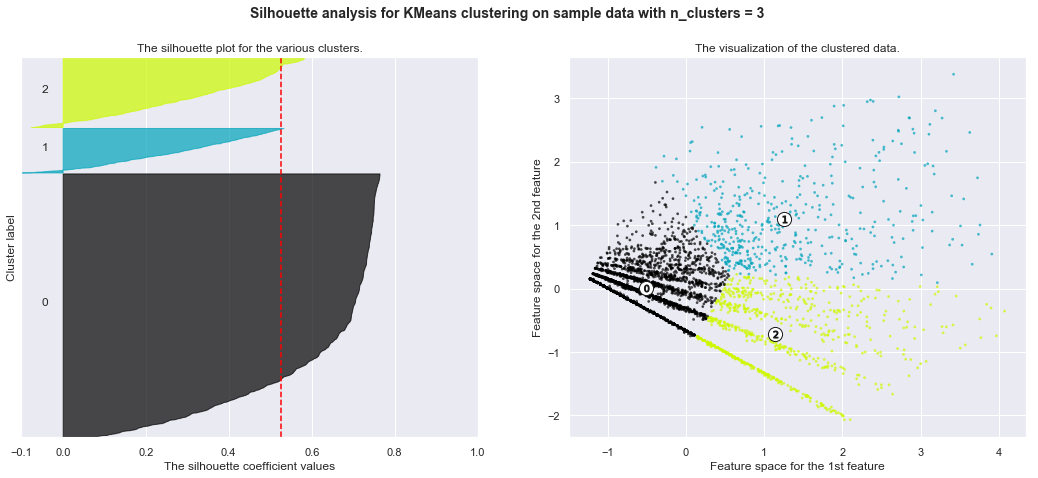

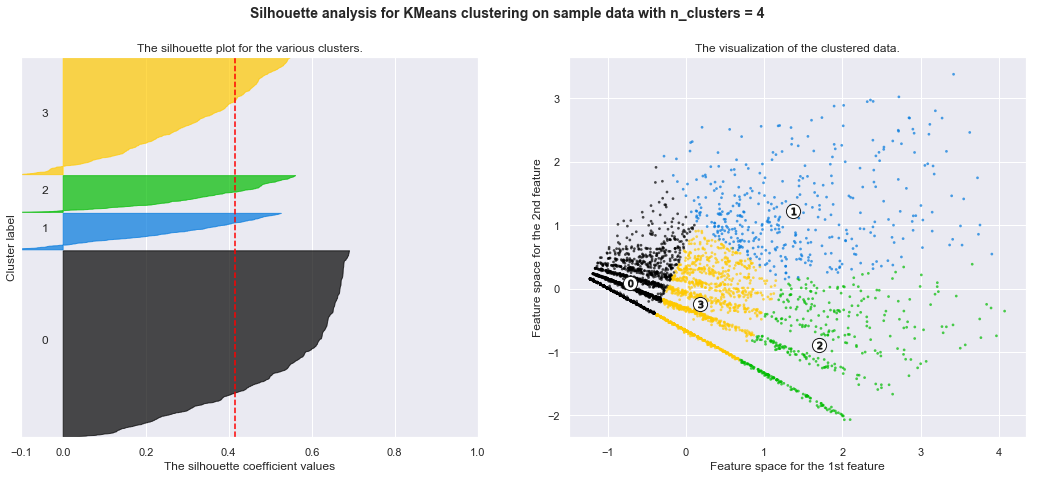

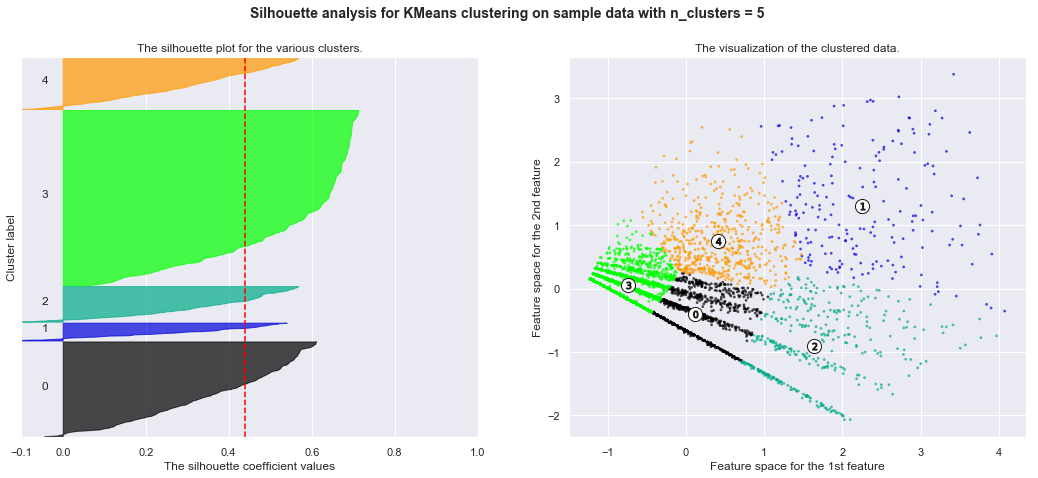

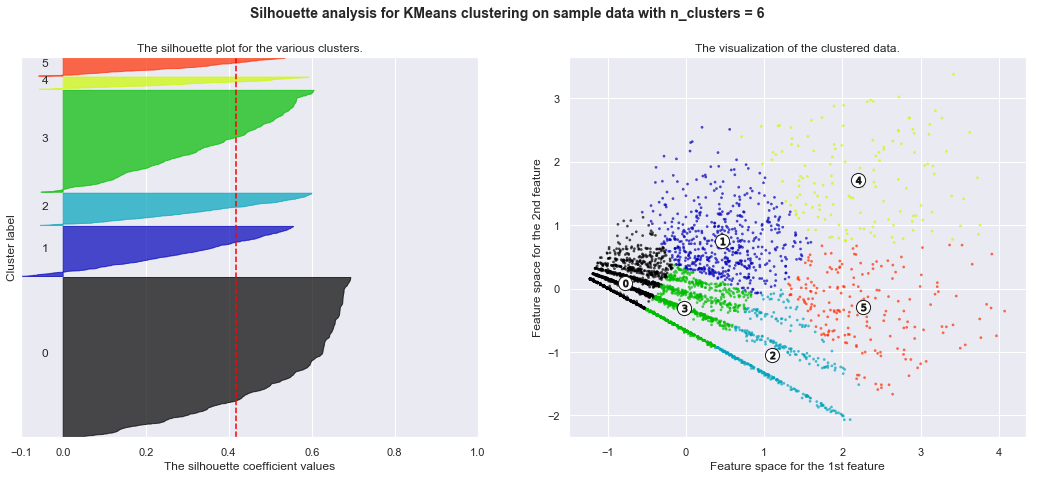

In [45]:
range_n_clusters = [2, 3, 4, 5, 6]

X = principalComponents

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### How do the values of principal components relate to the original dataset?
Running the same series of K-means on first 2 component from PCA, it is shown that there is a small drop in all instance of the silhouette score. This is quite to be expected since taking just 2 component from the PCA would result in some loss in the variance in the entire dataset. It is shown that the 2 component account for less than 60% of the variance in the cumulative explained variance graph.